In [3]:
import pandas as pd
pd.options.plotting.backend = "plotly"

### Load the sampled version of the dataset (5 000 songs)

In [4]:
df = pd.read_csv("./data/song_lyrics_sampled.csv")
print('Data rows number: ', len(df))
df.head()

Data rows number:  5000


,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Etap,rap,Der Plot,2014,124,{},"[Part I - Conny:]\nGuten Morgen fremdes Bett, ...",383522,de,de,de
1,Toothpick,pop,Biting Elbows,2012,8873,{},Some folks got the patience of the angels\nNot...,1166787,en,en,en
2,6 Feet Under,pop,Ana Johnsson,2004,60,{},You just left me 6 feet under ground I'm burni...,803057,en,en,en
3,Ir Al Baile,pop,Onda Vaga,2015,731,{},Cuando a los doce llevé la bandera en el hombr...,905848,es,es,es
4,Prudenza mai,pop,Ivan Graziani,1989,35,{},"Prudenza mai, mai...\nMai neanche da bambino\n...",1304379,it,it,it


### Drop useless columns and keep only english songs

In [5]:
# consider only english songs
df = df[df.language == 'en']
# drop rows containing NaN values
df = df.dropna()
# drop useless columns
df = df.drop(['language_cld3', 'language_ft','language','features','views'], axis=1)
print('Data rows number: ', len(df))
df.head()

Data rows number:  3919


,title,tag,artist,year,lyrics,id
1,Toothpick,pop,Biting Elbows,2012,Some folks got the patience of the angels\nNot...,1166787
2,6 Feet Under,pop,Ana Johnsson,2004,You just left me 6 feet under ground I'm burni...,803057
5,The Poetaster Act 4. Scene 2,misc,Ben Jonson,1601,"A Room in Lupus's House.\n\nEnter Lupus, HISTR...",674438
6,Hes Gone,pop,Phil Lesh & Friends,2015,"Rat in a drain ditch, caught on a limb, you kn...",961823
7,Ill Never Say,pop,Helen Ward,2015,"I'll never say ""never again"" again\nCause here...",1163619


### Dataset preprocessing

In [6]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt',quiet=True)
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)

stop_words = stopwords.words('english')
new_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa']
stop_words.extend(new_stop_words)


def preprocess_text(text):
    # remove \n
    text = text.replace('\n', ' ')
    # remove punctuation
    text = re.sub(r'[,\.!?]', '', text)
    #removing text in square braquet
    text = re.sub(r'\[.*?\]', ' ', text)
    #removing numbers
    text = re.sub(r'\w*\d\w*',' ', text)
    #removing bracket
    text = re.sub(r'[()]', ' ', text)
    #removing underscore at the beginning or at the end of the word
    text = re.sub(r'^_|_$', '', text)
    #removing multiple spaces (merge > 2 spaces in one space)
    text = re.sub(r' {2,}', ' ', text)
    # convert all words in lower case
    text = text.lower()
    # tokenize
    tokens = word_tokenize(text)
    # remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    #remove tokens with lenght < 3
    final_tokens = [token for token in lemmatized_tokens if len(token) > 2 and not token.isnumeric()]

    return ' '.join(final_tokens)

cleaned_text = df["lyrics"].apply(preprocess_text)
df["lyrics_proc_v2"] = cleaned_text
df.head()

,title,tag,artist,year,lyrics,id,lyrics_proc
1,Toothpick,pop,Biting Elbows,2012,Some folks got the patience of the angels\nNot...,1166787,folk got patience angel heart well yearns veng...
2,6 Feet Under,pop,Ana Johnsson,2004,You just left me 6 feet under ground I'm burni...,803057,left foot ground burning sight light foot buri...
5,The Poetaster Act 4. Scene 2,misc,Ben Jonson,1601,"A Room in Lupus's House.\n\nEnter Lupus, HISTR...",674438,room lupus house enter lupus histrio lictors t...
6,Hes Gone,pop,Phil Lesh & Friends,2015,"Rat in a drain ditch, caught on a limb, you kn...",961823,rat drain ditch caught limb know better know l...
7,Ill Never Say,pop,Helen Ward,2015,"I'll never say ""never again"" again\nCause here...",1163619,'ll never say never cause love head heel love ...


### Analysis

#### Genre

In [7]:
#plot genres
fig_genre = pd.DataFrame(df.tag.value_counts()).plot.bar(template='ggplot2')#title parameters
title_param = dict(text='<b>Count of Genre</b><br></b>',
                        font=dict(size=20))#update layout
fig_genre.update_layout(title=title_param,
                  width=700,
                  height=400,
                  xaxis = dict(title='Genre'),
                  yaxis = dict(title='Count'))#change the colour
fig_genre.update_traces(marker_color='rgb(148, 103, 189)')#show plot
fig_genre.show()

#### Lyrics length

In [8]:
#get lyric frequencies for each song
df['lyrics_num_tks'] = df['lyrics_proc'].map(lambda x: len(x.split()))
#empty list
lyric_count_df = []
#loop through each unique genre
for i in df.tag.unique():

    #get subset of genres appended to list
    lyric_count_df.append(pd.DataFrame(df[df.tag == i]['lyrics_num_tks']))

#concat all DataFrames where each column is a genre
word_counts = pd.concat([i for i in lyric_count_df],axis=1)
#update columns
word_counts.columns = df.tag.unique()
#plot lyric count distributon for each genre
fig_dist = word_counts.plot.box(template='ggplot2')

#title parameters
title_param = dict(text='<b>Distribution of lyrics length by genre</b><br></b>',
                        font=dict(size=20))

#margin parameters
margin_param=dict(l=25,r=25,b=50,t=50,pad=0)

#update layout
fig_dist.update_layout(title=title_param,
                       margin=margin_param,
                       width=700,
                       height=400,
                       xaxis = dict(title_text='Genre',title_font = dict(size=10),tickfont=dict(size=10)),
                       yaxis = dict(title_text='Song lyrics length (n tokens)',title_font = dict(size=10),tickfont=dict(size=10)))

#update colours
fig_dist.update_traces(marker_color='rgb(148, 103, 189)')

#show plot
fig_dist.show()

#### POS tagging

In [9]:
import spacy

#load spacy model
nlp = spacy.load('en_core_web_sm')

def pos(tks,pos):

    """Returns any token that qualifies as a specific part of speech"""
    #string = ' '.join(tks)
    doc = nlp(tks) #fit model

    return ' '.join(list(set([i.text for i in doc if i.pos_ == pos]))) #return any tokens that qualify

#get nouns
df['nouns'] = df.lyrics_proc.map(lambda x: pos(x,'NOUN'))

#get verbs
df['verbs'] = df.lyrics_proc.map(lambda x: pos(x,'VERB'))

#get adjectives
df['adjectives'] = df.lyrics_proc.map(lambda x: pos(x,'ADJ'))

#get adverbs
df['adverbs'] = df.lyrics_proc.map(lambda x: pos(x,'ADV'))

In [10]:
df.iloc[:5,-4:]

,nouns,verbs,adjectives,adverbs
1,skull release place ground stick angel light s...,eat bound drove moving look gave say got felt ...,red great moral strong bad low free lower flawed,softly better back maybe still well away halfway
2,leave wrong eye stroke sign ground time light ...,drown done leave gave burning learning gone st...,long open scar,apart still around far
5,jupiter plot dog piece rebellion politician lo...,shut give look tell take thank say knowing com...,sure pothecary private apothecary able physic ...,half forward yet here
6,roof rat dog limb steam smile gon cat skid mil...,told bring blow gone lost drain know left said...,right locomotive backhe cold hot steal old coo...,maybe better back
7,love goodbye thing sky hat thought heel head,kissing say cause missed walked kiss said die,sweet,away never


#### Common words

(-0.5, 1599.5, 799.5, -0.5)

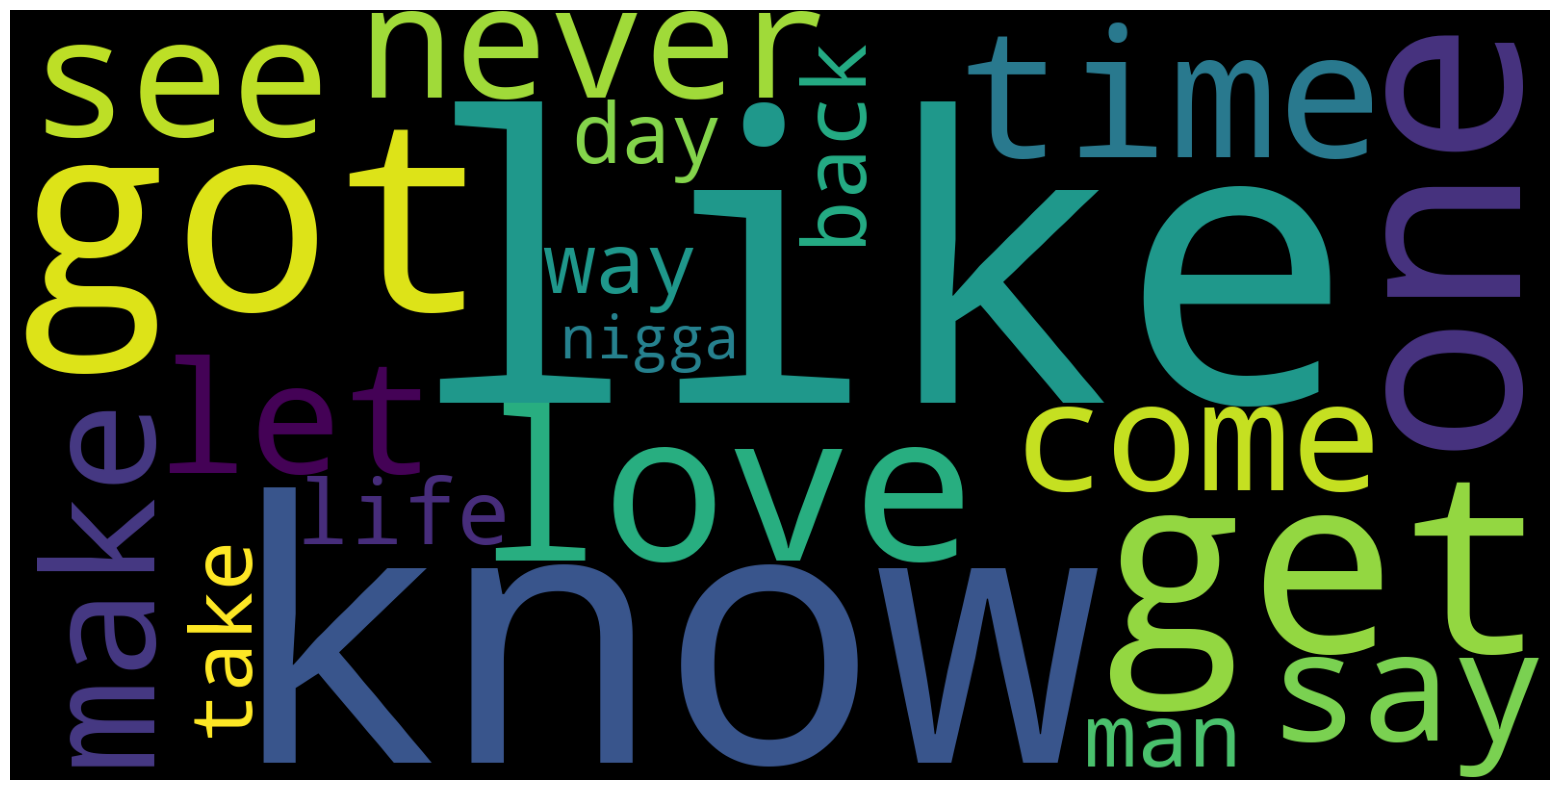

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def mostcommonTokens(data,token=1):

    """Returns a DataFrame of the most common n (arg)tokens in a string. Excludes stop words. Additional
    stop words can be added"""

    stop_words = stopwords.words('english')
    new_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa']
    stop_words.extend(new_stop_words)

    #instantiate count vectorizer and specify tokens
    vect = CountVectorizer(stop_words=stop_words, ngram_range= (token,token))

    #fit vectorizer
    X = vect.fit_transform(data)

    #get word counts as DataFrame
    word_counts = pd.DataFrame(np.asarray(X.sum(axis=0))[0],vect.get_feature_names_out(),columns=['count'])

    #sort by count
    word_counts = word_counts.sort_values(by='count', ascending=False)

    return word_counts #return DataFrame

top_tks = mostcommonTokens(df.lyrics_proc,token=1).head(20)
wordcloud = WordCloud(background_color='black', width = 1600, height = 800,collocations=False,random_state=100,stopwords=stopwords.words('english')).generate_from_frequencies(top_tks['count'].to_dict())
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")

#### Common words tagged as name by genre

In [12]:
import plotly.express as px

pos = 'nouns'
n = 100
#list to populate subset DataFrame's
all_df = []

#loop through unique genres
for i in df.tag.unique():

    #get most common tokens for part of speech
    temp_df = mostcommonTokens(df[df['tag'] == i][pos]).head(n)

    #add column for current genre
    temp_df['tag'] = i

    #append DataFrame to list
    all_df.append(temp_df)

#concatenate all DataFrame's
all_df = pd.concat([i for i in all_df])

#reset index
all_df.reset_index(drop=False,inplace=True)

#column labels
all_df.columns = ['word','count','tag']

# in order to have a single root node add 'all genres'
all_df["all genres"] = "all genres"

#create plotly treemap figure
fig = px.treemap(all_df, path=['all genres', 'tag', 'word'], values='count',)

#title parameters
title_param = dict(text='<b>Most Common Nouns, by genre</b><br>spaCy used for classifying PoS</b>',
                    font=dict(size=20))

#update layout
fig.update_layout(title=title_param,
                font= dict(family='Helvetica',size=10),
                width=900,
                height=900,
                autosize=False,
                margin=dict(l=40,r=40,b=85,t=100,pad=0,))

#show plot
fig.show()

In [13]:
#df.to_csv("./data/song_lyrics_sampled_proc.csv", header='true', index=False)

# Topic Modeling
## LDA - Gensim Library

In [14]:
df = pd.read_csv("./data/song_lyrics_sampled_proc.csv")
print('Data rows number: ', len(df))
df.head()

Data rows number:  3919


,title,tag,artist,year,lyrics,id,lyrics_proc,lyrics_num_tks,nouns,verbs,adjectives,adverbs
0,Toothpick,pop,Biting Elbows,2012,Some folks got the patience of the angels\nNot...,1166787,folk got patience angel heart well yearns veng...,183,gon light smoking yearns angel folk rate idiot...,stole ' done look drove moving felt say leave ...,low flawed great strong bad free red lower moral,softly back well halfway away still maybe better
1,6 Feet Under,pop,Ana Johnsson,2004,You just left me 6 feet under ground I'm burni...,803057,left foot ground burning sight light foot buri...,104,light sign burning leave wrong ground eye life...,drown burning done leave left gone buried brok...,long scar open,far still apart around
2,The Poetaster Act 4. Scene 2,misc,Ben Jonson,1601,"A Room in Lupus's House.\n\nEnter Lupus, HISTR...",674438,room lupus house enter lupus histrio lictors t...,178,experiment project purchase poison letter dog ...,shut worship look say directed enter going tak...,sure much cunning pothecary apothecary private...,half yet here forward
3,Hes Gone,pop,Phil Lesh & Friends,2015,"Rat in a drain ditch, caught on a limb, you kn...",961823,rat drain ditch caught limb know better know l...,124,gon cat skid roof dog goin wind mountain mile ...,blow gone drain bring left know lost told said...,strange cool right backhe locomotive steal hig...,maybe back better
4,Ill Never Say,pop,Helen Ward,2015,"I'll never say ""never again"" again\nCause here...",1163619,'ll never say never cause love head heel love ...,40,head hat sky thought heel love thing goodbye,die missed said kiss walked cause kissing say,sweet,away never


### Dictionary and Vector Corpus

In [15]:
from gensim import corpora
from gensim.models import TfidfModel

# Create the dictionary
dictionary = corpora.Dictionary(df['lyrics_proc'].apply(lambda x: x.split()))

# Create the corpus
corpus = [dictionary.doc2bow(text.split()) for text in df['lyrics_proc']]

# Build the Tf-Idf model
tfidf = TfidfModel(corpus)

# Save the dictionary and corpus for future use
dictionary.save('dictionary.gensim')
corpora.MmCorpus.serialize('corpus.mm', corpus)

### Model training

In [16]:
from gensim.models import LdaModel

# Set the number of topics
num_topics = 10

# Train the LDA model
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Save the trained model
lda_model.save('lda_model.gensim')

In [17]:
# Load the trained LDA model
lda_model = LdaModel.load('lda_model.gensim')

# Print the most relevant keywords for each topic
topics = lda_model.print_topics(num_topics=num_topics, num_words=5)
for topic in topics:
    print(topic)

(0, '0.021*"n\'t" + 0.018*"get" + 0.007*"like" + 0.005*"let" + 0.005*"back"')
(1, '0.022*"like" + 0.005*"man" + 0.004*"white" + 0.004*"one" + 0.004*"swag"')
(2, '0.019*"god" + 0.018*"law" + 0.017*"christ" + 0.015*"walk" + 0.011*"say"')
(3, '0.007*"one" + 0.005*"away" + 0.005*"day" + 0.005*"come" + 0.005*"eye"')
(4, '0.008*"would" + 0.008*"one" + 0.008*"said" + 0.006*"man" + 0.005*"thing"')
(5, '0.025*"n\'t" + 0.024*"like" + 0.019*"got" + 0.018*"nigga" + 0.014*"get"')
(6, '0.007*"state" + 0.005*"government" + 0.005*"power" + 0.004*"american" + 0.004*"war"')
(7, '0.024*"solness" + 0.016*"hilda" + 0.007*"sebastian" + 0.006*"christmas" + 0.006*"antonio"')
(8, '0.037*"n\'t" + 0.019*"know" + 0.016*"love" + 0.014*"\'re" + 0.013*"\'ll"')
(9, '0.020*"thou" + 0.017*"thy" + 0.013*"shall" + 0.012*"thee" + 0.012*"god"')


### Using the trained model

In [21]:
# Preprocess the test lyric
test_lyric = preprocess_text("folk got patience angel heart well yearns vengeance leave place gon leave smoking heart healed rib broken heart healed rib broken leave place bound leave smoking gas floor see moving ground park brake hold release halfway across town eat red light chew tram track stole moral n't need back got stand problem museum evening dull stick toothpick skull see n't know maybe n't undergo think 've idiot one saw fucking thing night drove away scott free back home night gave forehead wipe rate felt great shit petrol low still low woman expects well 'll heck lot lower done 'll eat red light chew tram track stole moral n't need back got stand problem museum evening dull stick toothpick skull see n't know maybe n't undergo think 've idiot one saw fucking thing night drove away scott free back home night gave forehead wipe rate felt great strong word softly spoken stayed strong grin five mile one uppercut chin chin better watch say better watch say n't crossed n't crossed n't know maybe n't undergo think feel bad eye law look upon like flawed")

# Convert the preprocessed test lyric into a bag-of-words representation
test_bow = dictionary.doc2bow(test_lyric.split())

# Apply the trained LDA model to the test lyric
topic_distribution = lda_model.get_document_topics(test_bow)

# Print the topic distribution
for topic in topic_distribution:
    print(f"Topic {topic[0]}: {topic[1]}")

Topic 3: 0.22219626605510712
Topic 4: 0.04953426867723465
Topic 5: 0.1421780288219452
Topic 8: 0.5828192830085754


In [33]:
# Get the topic with the highest score
highest_topic = max(topic_distribution, key=lambda x: x[1])
print(highest_topic)

# Get the main keywords for the highest topic
main_keywords = lda_model.show_topic(highest_topic[0], topn=5)

# Return the representation through the main keywords
representation = [keyword[0] for keyword in main_keywords]

representation

(8, 0.5828193)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



["n't", 'know', 'love', "'re", "'ll"]

### Visualization

In [28]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

# Convert the corpus to a gensim-specific format
gensim_corpus = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(gensim_corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

